#### Splitting Data

In [ ]:
import os
import random
import shutil

def split_images(source_dir, dest_dir, split_ratio=0.8):
    # Create target directories if they don't exist
    train_dir = os.path.join(dest_dir, "train")
    val_dir = os.path.join(dest_dir, "val")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get list of classes from source directory
    classes_list = [folder for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder))]

    # Create class-wise directories in train and val folders
    for class_name in classes_list:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move images to respective directories based on split ratio
    for class_name in classes_list:
        class_images = [f for f in os.listdir(os.path.join(source_dir, class_name)) if f.endswith('.jpg') or f.endswith('.png')]
        random.shuffle(class_images)
        split_index = int(len(class_images) * split_ratio)

        for i, img_name in enumerate(class_images):
            source_path = os.path.join(source_dir, class_name, img_name)
            if i < split_index:
                target_path = os.path.join(train_dir, class_name, img_name)
            else:
                target_path = os.path.join(val_dir, class_name, img_name)
            shutil.copy(source_path, target_path)
            print(f"Copied {img_name} to {'train' if i < split_index else 'val'}/{class_name}")

if __name__ == "__main__":
    source_directory = "path/to/source_directory"
    destination_directory = "path/to/destination_directory"
    split_ratio = 0.8  # Adjust split ratio as needed

    split_images(source_directory, destination_directory, split_ratio)


#### Training Code Started

In [8]:
import zipfile
import os

zip_file_path = './custom_dataset.zip'

# Extract destination directory path
extract_path = './'

# Extract zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
extracted_files = os.listdir(extract_path)
print("Dataset extracted successfully!")
print("Extracted files:", extracted_files)


Dataset extracted successfully!
Extracted files: ['custom_dataset', 'train', 'val']


In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

# !pip install helper_functions
from torch import nn
from torchvision import transforms

# import sys
# sys.path.append('./')

from helper_functions import set_seeds


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os

# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
base_dir = './custom_dataset/train/'

# Check if base directory exists
if not os.path.exists(base_dir):
    print(f"Error: {base_dir} does not exist.")
else:
    # Get all folder names inside base directory
    folder_names = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

    # Print and store folder names in class_names list
    class_names = folder_names
    print(f"Folder names inside {base_dir}: {folder_names}")
    print(f"class_names list: {class_names}")

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Folder names inside ./custom_dataset/train/: ['MIdata', 'non-MIdata']
class_names list: ['MIdata', 'non-MIdata']


In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [5]:
# Setup directory paths to train and test images
train_dir = './custom_dataset/train/'
test_dir = './custom_dataset/val/'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [21]:
from PIL import Image

pretrained_vit_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [22]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )
    return train_dataloader, test_dataloader, class_names

In [23]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_vit_transforms,
                                                                                          batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [24]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=2,
                                      device=device)

  0%|          | 0/2 [00:00<?, ?it/s]


PicklingError: Can't pickle <function <lambda> at 0x0000023D172E74C0>: attribute lookup <lambda> on __main__ failed

In [11]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from helper_functions import set_seeds
from going_modular.going_modular import engine
from PIL import Image

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    class_names = train_data.classes

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_dataloader, test_dataloader, class_names

# Ensure that the necessary variables are defined
# train_dir = 'path/to/train_dir'  # Update with the actual path
# test_dir = 'path/to/test_dir'  # Update with the actual path
pretrained_vit_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Debugging: Print the type of image data
def debug_image_loading(dataloader):
    for batch, (images, labels) in enumerate(dataloader):
        print(f"Batch {batch}: Image type: {type(images)}, Image dtype: {images.dtype}")
        break  # Only check the first batch

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32
)

# Debugging: Check the image data types
debug_image_loading(train_dataloader_pretrained)
debug_image_loading(test_dataloader_pretrained)

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility
set_seeds()

# Train the classifier head of the pretrained ViT feature extractor model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=2,
    device=device
)


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torchvision\datasets\folder.py", line 247, in __getitem__
    sample = self.transform(sample)
             ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torchvision\transforms\transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torchvision\transforms\transforms.py", line 137, in __call__
    return F.to_tensor(pic)
           ^^^^^^^^^^^^^^^^
  File "c:\Users\HNH TECH SOLUTIONS\Envs\vision\Lib\site-packages\torchvision\transforms\functional.py", line 168, in to_tensor
    img = torch.from_numpy(np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Numpy is not available


In [12]:
import numpy as np
print(np.__version__)


2.0.0


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


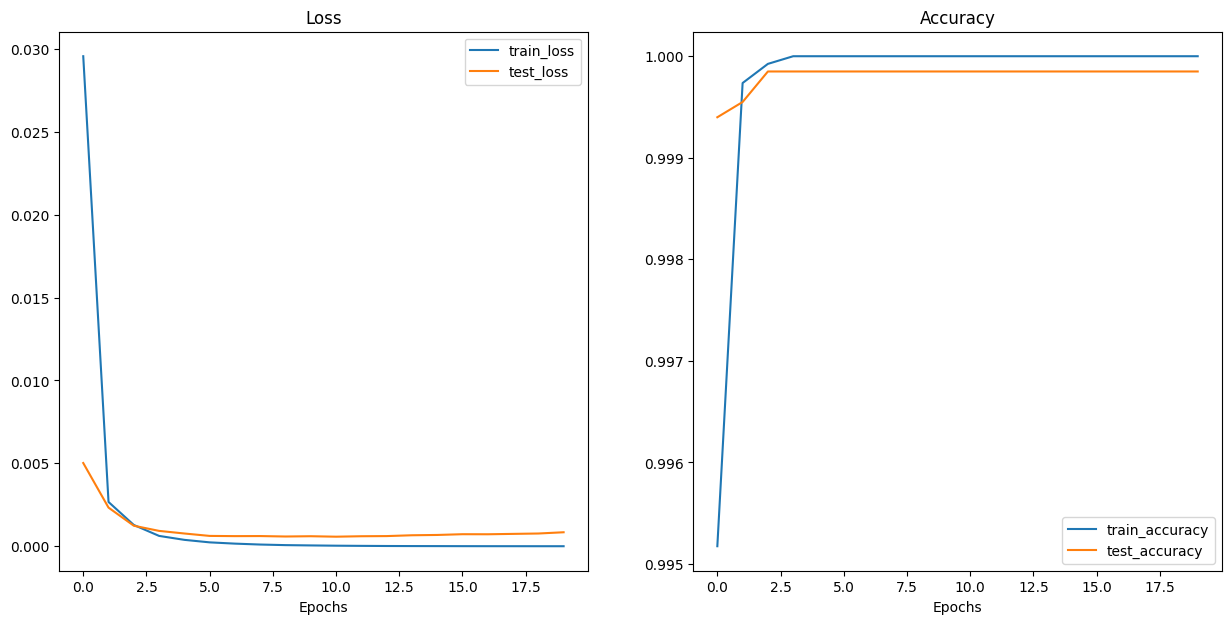

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

Model Save


In [ ]:
import torch

# Specify the file path where you want to save the model
model_save_path = '/content/drive/MyDrive/Echo/ischemia_mi_as-ai_20_epochs_model.pth'  # Update the path as needed

# Save the model state dictionary and class_names
torch.save({
    'model_state_dict': pretrained_vit.state_dict(),
    'class_names': class_names
}, model_save_path)

print(f"Model and class_names saved successfully at: {model_save_path}")

Model and class_names saved successfully at: /content/drive/MyDrive/Echo/ischemia_mi_as-ai_20_epochs_model.pth


## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

In [10]:
# !pip install timm

import torch
import timm

# Define the ViT model architecture
class CustomVisionTransformer(torch.nn.Module):
    def __init__(self, model_name, num_classes):
        super(CustomVisionTransformer, self).__init__()
        # Load the ViT model from timm
        self.model = timm.create_model(model_name, pretrained=False)
        # Modify the classifier head for the specified number of classes
        self.model.head = torch.nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Specify the file path from which you want to load the model
model_load_path = '/content/drive/MyDrive/Echo/ischemia_mi_as-ai_20_epochs_model.pth'  # Update the path as needed

# Load the model and class_names
checkpoint = torch.load(model_load_path)

# Initialize your ViT model instance with the desired configuration
loaded_model = CustomVisionTransformer(model_name='vit_base_patch16_224', num_classes=len(checkpoint['class_names']))

# Load model state_dict from the checkpoint
state_dict = checkpoint['model_state_dict']
new_state_dict = {}

for k, v in state_dict.items():
    # Map keys from loaded state_dict to match model's state_dict keys
    if k.startswith('model.'):  # Example mapping
        k = k.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[k] = v

# Load mapped state_dict
loaded_model.load_state_dict(new_state_dict, strict=False)

# Load class_names from the checkpoint
loaded_class_names = checkpoint['class_names']


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

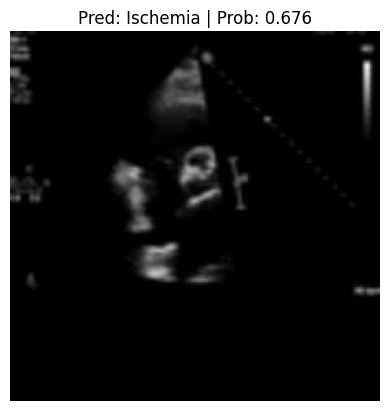

In [11]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Echo/Data/Test/AS_AI/2200s1_22.jpg"

# Predict on custom image
pred_and_plot_image(model=loaded_model,
                    image_path=custom_image_path,
                    class_names=loaded_class_names)

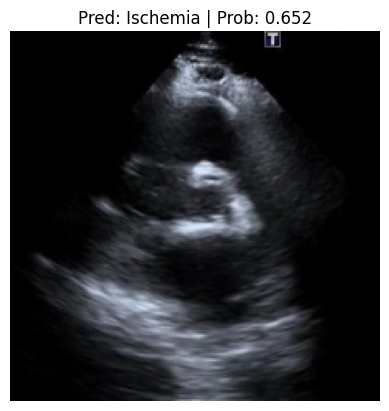

In [12]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Echo/Data/Test/Ischemia/Image04598977454341148_1.jpg"

# Predict on custom image
pred_and_plot_image(model=loaded_model,
                    image_path=custom_image_path,
                    class_names=loaded_class_names)